# ADA Project - DataBrewers

The aim of this project is to analyze beer preference shifts across seasons and events, with a focus on understanding consumer trends in taste, aroma, palate, and appearance. By examining variation in ratings for beer style and alcohol content among US users, and comparing different states with varying weather conditions, we seek to identify seasonal trends. To deepen our understanding, we will conduct sentiment analysis to capture the tone of reviews and references to seasons, weather, or events, and correlate these insights with ratings. Our findings will provide actionable insights for professionals (brewers, marketers, etc.) by highlighting customer preferences throughout the year. Understanding these seasonal trends enables brewers to adjust product offerings to align more closely with consumer demand. As a conclusion of to our research, we could suggest the best beer that would be the perfect match for each season/festivity, in the form of a time fresco.

## Table of content


- Data pre-processing
- Seasonal trend analysis
    - Seasonal influence on beer ratings for low and high ABV beers
    - Seasonal trend in beer ratings across US states
- Sentiment analysis
- Semantic analysis

## Data pre-processing 


In [9]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import wordcloud
import nltk
import sys
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import geopandas as gpd

The exploratory analysis is detailed in the notebook `data_cleaning.ipynb`. We decided to choose only the BeerAdvocate dataset, as it contains a sufficient number of user ratings and reviews. By analyzing the country of origin from the users, we discovered that most of the ratings were provided by users from the United States. Therefore, we restricted the dataset to include only American reviews.
 
 The complete processing and cleaning workflow is implemented in `src/scripts/preprocessing.py`. In this script, we begin by loading the raw data files for beers, reviews, users, breweries, and ratings. User location is split into country and state, and non-US users are filtered out. We then assign a US region (e.g. Northeast, Midwest) to each entry based on the user's state. Beer styles are simplified by removing country prefixes like "Belgian" or "American" and reclassified into broader categories using a style map. The script also categorizes beer based on their Alcohol By Volume (ABV) values, dividing them into three categories (low, medium, and high) using a quantile-based thresholds. We assign a season to each reviews based on the month it was published (e.g. Spring, Summer, Fall, Winter). The dataset is filtered to only include years with at least 70,000 reviews. Missing values in the rating column are handled by removing rows where ratings are missing. Finally, the cleaned versions of the datasets are saved as compressed `csv`files in the `data/cleaned/`directory. 

In [3]:
# Run the preprocessing script
# %run src/scripts/preprocessing.py

#### Loading the data

In [4]:
reviews = pd.read_csv('data/cleaned/reviews.csv.gz', compression='gzip')
ratings = pd.read_csv('data/cleaned/ratings.csv.gz', compression='gzip')
users = pd.read_csv('data/cleaned/users.csv.gz', compression='gzip')
beers_ba = pd.read_csv('data/cleaned/beers.csv.gz', compression='gzip')
breweries_ba = pd.read_csv('data/cleaned/breweries.csv.gz', compression='gzip')

#### Importation of the scripts

In [5]:
import sys
sys.path.append('src')

import scripts.sentiment_analysis as sent_ana
import scripts.categorization as categ
import scripts.plot as plot
import scripts.statistics as stats

## Seasonal trend analysis


To understand the seasonal analysis, it is important to understand how the beers are rated. In both reviews and ratings dataframes, 6 columns contain metrics ( which are a score out of 5): appearance, aroma, taste, mouthfeel, overall and rating. The rating metrics is computed based on the 5 other scores with the following formula:
$$
\text{Rating} = 0.06 \cdot \text{Appearance} + 0.24 \cdot \text{Aroma} + 0.4 \cdot \text{Taste} + 0.1 \cdot \text{Mouthfeel} + 0.2 \cdot \text{Overall}
$$

### Seasonal influence on beer ratings for low and high ABV beers
Beers are also characterized by their Alcohol By Volume (ABV), which was categorized into three groups during the preprocessing and cleaning phase: low, middle, and high. We are interested to see whether the ratings of low ABV or high ABV beers are influenced by seasonal changes throughout the year.

We focus only on the "rating" metric out of the five others, as similar trends were observed across all of them, and the "rating" metric is derived from the other five scores. A detailed analysis of the individual metrics can be found in the notebook `seasonal_trend_analysis.ipynb`.

In [6]:
mean_ratings = ratings.groupby(['season', 'abv_category'], as_index=False, observed=False)['rating'].mean()

# Separate data for high and low alcohol content
high_abv = mean_ratings[mean_ratings['abv_category'] == 'high']
low_abv = mean_ratings[mean_ratings['abv_category'] == 'low']

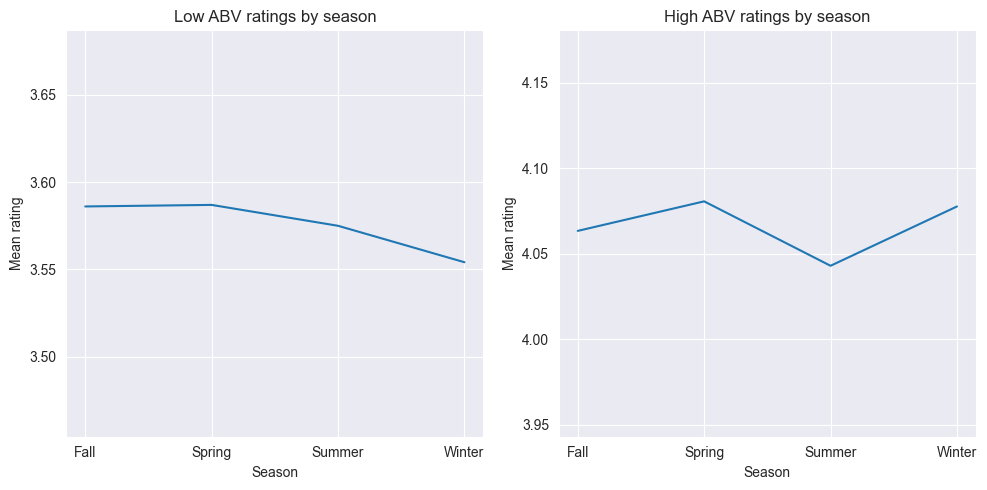

In [7]:
plot.plot_high_low_abv_trends(high_abv, low_abv)

In [ ]:
stats.test_seasonal_significance_ABV(ratings, 'low')

ANOVA and Turkey HSD tests revealed that all observed differences in rating between seasons are statistically significant, except for Fall vs. Spring in the low ABV category.

- **Low ABV beers**: These beers are rated highest in Spring, and lowest in Winter (~0.03 difference)

- **High ABV beers**: These beers receive the best ratings during Winter and the lowest in Summer (~0.04 difference)

### Seasonal trend in beer ratings across US states

Since we did not observe a significant difference in beer style preferences across seasons at the scale of the United States, we are interested to see whether there will be more pronounced changes at the state level.

First, the states were divided into three different categories:
- **Northeast** (e.g. New-York)
- **South** (e.g. Texas)
- **West** (e.g. California)
- **Midwest** (e.g. Minnesota)

We first hypothesize that, since the four regions experience varying weather conditions throughout the seasons, this may impact their ratings. However, analysis conducted in the `seasonal_trend_analysis.ipynb` notebook shows that the trends in ratings for the regions individually were not significantly different from the overall trend for the United States, particularly for the low and high ABV categories, as shown below:

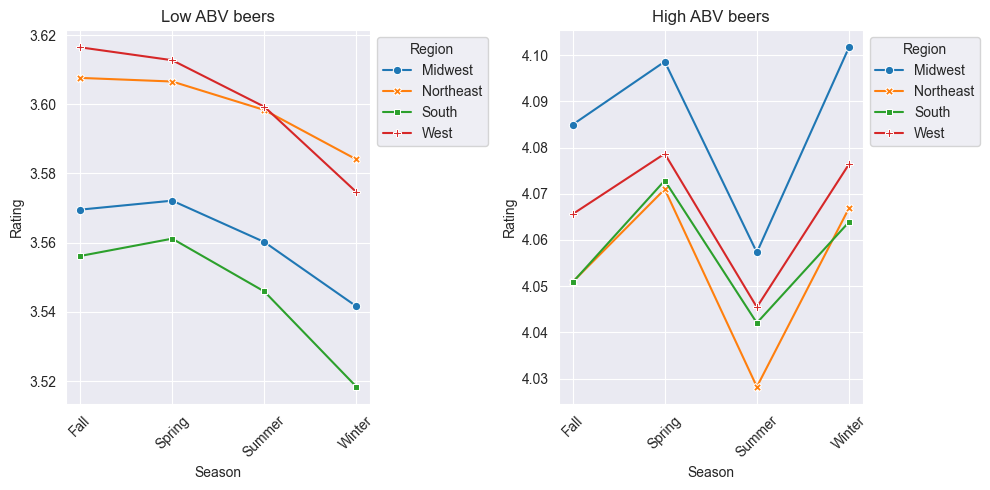

In [8]:
plot.plot_abv_seasonal_trends(ratings, "rating")

We are then interested in exploring the preferred beer styles across states and seasons. By doing so, we may be able to observe more pronounced changes and get more insights on how the season influences the appreciation of different beer styles.

In [10]:
# Strip the state names
ratings['states'] = ratings['states'].str.strip()

# Regroup reviews by states, season and style
state_season_style = (ratings.groupby(['states', 'season', 'style_simp'], observed=False)
                          .agg({'rating': 'mean'})
                          .reset_index())

# Keep only the highest rated style for each state-season
highest_rated_style = (
        state_season_style.loc[state_season_style.groupby(['states', 'season'], observed=False)['rating'].idxmax()]
        .reset_index(drop=True)
    )

In [ ]:
plot.plot_highest_rated_styles_by_season(highest_rated_style)

## Sentiment analysis

In this section we look at the words used in the review to try to determine the ones that are associated to positive reviews and the ones associated to negative ones.

- We define that a beer is positively graded if the rating grade strictly bigger than 4/5.
- We define that a beer is negatively graded if the rating grade strictly less than 3/5.

This will allow use to determine the aspects of a beer that are liked or disliked by reviewers. This way we will be able to understand better the consumer preferences

In [ ]:
# The semansentimenttic analysis script are download as sent_ana

# We download the stopwords to use them in the sentiment analysis
nltk.download('stopwords')

In [ ]:
# We begin by cleaning the reviews 
reviews_clean = sent_ana.clean_data(reviews)

# Separate the reviews into two groups: those with a rating higher than 4 and those with a rating lower than 3
reviews_high = reviews_clean[reviews_clean['rating'] > 4]
reviews_low = reviews_clean[reviews_clean['rating'] < 3]

# Tokenize the reviews
bigrams_high, bigrams_low = sent_ana.get_words(reviews_high, reviews_low)

# Count bigram frequencies for each group
bigram_freq_high = Counter(bigrams_high)
bigram_freq_low = Counter(bigrams_low)

To make it easier to visualise, we use Word Clouds, this way we can easily see the pair of words that are the most used, both for high and low ratings.

In [ ]:
# Generate the word clouds
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_high)
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_low)

# We plot word clouds for both groups
sent_ana.plot_and_save_word_clouds(wordcloud_high, wordcloud_low)

Now that we know the pair of words that are the most used in reviews with high ratings (>4/5) and low ratings (<3/5), we can see that some pair of words seem specific to well rated beers, and some seem specific to poorly rated beers.

We further investigate this to extract pair of words used only positively and pair of words used only negatively. This will allow us to determine the user preferences and potentially what makes a beer enjoyable or not.

In [ ]:
# We compare the most common bigrams in both groups and
df_comparison = sent_ana.compare_high_low(bigram_freq_high, bigram_freq_low, reviews_high, reviews_low)

# We plot the comparison
print(df_comparison)

We can easily see that some pair of words can be associated to both positive and negative reviews, but there are also words that are used only for one of the two.

We have that the following pair of words only appear in positive reviews:
- dark chocolate
- well balanced
- dark fruits
- brown sugar
- full bodied
- medium bodied

While the followinfg pair of words only appear in negative reviews: 
- finger color
- yellow color
- light bodied
- pale yellow

## Semantic analysis

In [1]:
import src.scripts.semantic_analysis as sem_ana

In [ ]:
clean_reviews = sem_ana.get_cleaned_reviews(reviews)

In [ ]:
top_20_words,word_freq = sem_ana.get_top_words(clean_reviews, 20)

In [ ]:
sem_ana.gen_wordcloud(word_freq)

In [ ]:
sem_ana.sentiment_analysis(word_freq)

In [ ]:
sem_ana.analyse_flavours(clean_reviews)